In [10]:
import os, torch, torchaudio, pandas as pd
from torch import nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bundle = torchaudio.pipelines.WAV2VEC2_BASE
wav2vec_model = bundle.get_model().to(device).eval()

TRAIN_AUDIO_DIR = "../dataset/audios_train"
TEST_AUDIO_DIR = "../dataset/audios_test"
TRAIN_CSV_PATH = "../dataset/train.csv"
TEST_CSV_PATH = "../dataset/test.csv"

BEST_LEARNING_RATE = 0.0004956131596941485
BEST_BATCH_SIZE = 32
BEST_EPOCHS = 80
BEST_DROPOUT_RATE = 0.3183369837123387
BEST_NUM_HIDDEN_LAYERS = 2
BEST_HIDDEN_DIM = 128
FINAL_MODEL_PATH = "final_regression_model_submit.pt"

In [3]:
class AudioDataset(Dataset):
    def __init__(self, csv_path, audio_dir, is_test=False):
        self.df = pd.read_csv(csv_path)
        self.audio_dir = audio_dir
        self.is_test = is_test

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        waveform, sr = torchaudio.load(os.path.join(self.audio_dir, row['filename']))
        if sr != bundle.sample_rate:
            waveform = torchaudio.transforms.Resample(sr, bundle.sample_rate)(waveform)
        if waveform.shape[0] > 1:
            waveform = waveform.mean(dim=0, keepdim=True)
        waveform = waveform.to(device)

        if self.is_test:
            return waveform, row['filename']
        else:
            label = torch.tensor(float(row['label']), dtype=torch.float32).to(device)
            return waveform, label

In [4]:
class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)

class RegressionHead(nn.Module):
    def __init__(self, input_dim, num_hidden_layers, hidden_dim, dropout_rate):
        super().__init__()
        layers = [nn.LayerNorm(input_dim)]
        current_dim = input_dim
        for _ in range(num_hidden_layers):
            layers.extend([
                nn.Linear(current_dim, hidden_dim),
                Swish(),
                nn.Dropout(dropout_rate)
            ])
            current_dim = hidden_dim
        layers.append(nn.Linear(current_dim, 1))
        self.mlp = nn.Sequential(*layers)

    def forward(self, x):
        return self.mlp(x).squeeze(1)

In [5]:
def extract_features(waveform):
    with torch.no_grad():
        if waveform.dim() == 3:
            waveform = waveform.squeeze(1)
        features, _ = wav2vec_model.extract_features(waveform)
        selected_layers = features[-3:]
        stat_feats = [torch.cat([layer.mean(1), layer.std(1)], dim=1) for layer in selected_layers]
        return torch.cat(stat_feats, dim=1)

def collate_fn_train(batch):
    waveforms = [x[0] for x in batch]
    labels = torch.stack([x[1] for x in batch])
    return waveforms, labels

def collate_fn_test(batch):
    waveforms = [x[0] for x in batch]
    filenames = [x[1] for x in batch]
    return waveforms, filenames

In [6]:
def train_final():
    train_dataset = AudioDataset(TRAIN_CSV_PATH, TRAIN_AUDIO_DIR, is_test=False)
    train_loader = DataLoader(train_dataset, batch_size=BEST_BATCH_SIZE, shuffle=True, collate_fn=collate_fn_train)

    input_dim = extract_features(torch.randn(1, 16000).to(device)).shape[1]
    final_model = RegressionHead(input_dim, BEST_NUM_HIDDEN_LAYERS, BEST_HIDDEN_DIM, BEST_DROPOUT_RATE).to(device)

    optimizer = torch.optim.AdamW(final_model.parameters(), lr=BEST_LEARNING_RATE)
    criterion = nn.MSELoss()

    print("Starting final training with best hyperparameters...")
    for epoch in range(BEST_EPOCHS):
        final_model.train()
        total_loss = 0.0
        for waveforms, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{BEST_EPOCHS} [Train]"):
            feats = torch.cat([extract_features(wf.unsqueeze(0)).cpu() for wf in waveforms], dim=0).to(device)
            preds = final_model(feats)
            loss = criterion(preds, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_train_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{BEST_EPOCHS}: Train Loss={avg_train_loss:.4f}")

    torch.save(final_model.state_dict(), FINAL_MODEL_PATH)
    print(f"✔️ Final model saved to {FINAL_MODEL_PATH}")

In [7]:
def evaluate_final():
    if not os.path.exists(FINAL_MODEL_PATH):
        print(f"Error: Final model not found at {FINAL_MODEL_PATH}. Please run train_final() first.")
        return

    test_dataset = AudioDataset(TEST_CSV_PATH, TEST_AUDIO_DIR, is_test=True)
    test_loader = DataLoader(test_dataset, batch_size=BEST_BATCH_SIZE, shuffle=False, collate_fn=collate_fn_test)

    input_dim = extract_features(torch.randn(1, 16000).to(device)).shape[1]
    final_model = RegressionHead(input_dim, BEST_NUM_HIDDEN_LAYERS, BEST_HIDDEN_DIM, BEST_DROPOUT_RATE).to(device)
    final_model.load_state_dict(torch.load(FINAL_MODEL_PATH))
    final_model.eval()

    print("Starting final evaluation on the test set...")
    all_preds = []
    all_filenames = []

    with torch.no_grad():
        for waveforms, filenames in tqdm(test_loader, desc="Evaluating"):
            feats = torch.cat([extract_features(wf.unsqueeze(0)).cpu() for wf in waveforms], dim=0).to(device)
            preds = final_model(feats)
            all_preds.extend(preds.cpu().numpy())
            all_filenames.extend(filenames)

    output_df = pd.DataFrame({
        'filename': all_filenames,
        'label': all_preds
    })
    output_df.iloc[:, 1] = output_df.iloc[:, 1].apply(lambda x: round(x * 2) / 2)
    output_df.to_csv("test_predictions_regression_submit.csv", index=False)
    print("✔️ Predictions saved to test_predictions_regression_submit.csv")

In [8]:
if __name__ == "__main__":
    train_final()
    evaluate_final()

Starting final training with best hyperparameters...


Epoch 1/80 [Train]: 100%|██████████| 14/14 [01:47<00:00,  7.65s/it]


Epoch 1/80: Train Loss=4.1807


Epoch 2/80 [Train]: 100%|██████████| 14/14 [02:02<00:00,  8.76s/it]


Epoch 2/80: Train Loss=1.6997


Epoch 3/80 [Train]: 100%|██████████| 14/14 [02:05<00:00,  8.96s/it]


Epoch 3/80: Train Loss=1.6606


Epoch 4/80 [Train]: 100%|██████████| 14/14 [02:06<00:00,  9.01s/it]


Epoch 4/80: Train Loss=1.4475


Epoch 5/80 [Train]: 100%|██████████| 14/14 [02:06<00:00,  9.01s/it]


Epoch 5/80: Train Loss=1.2283


Epoch 6/80 [Train]: 100%|██████████| 14/14 [02:05<00:00,  8.99s/it]


Epoch 6/80: Train Loss=1.1366


Epoch 7/80 [Train]: 100%|██████████| 14/14 [02:06<00:00,  9.03s/it]


Epoch 7/80: Train Loss=1.1667


Epoch 8/80 [Train]: 100%|██████████| 14/14 [02:06<00:00,  9.03s/it]


Epoch 8/80: Train Loss=1.0944


Epoch 9/80 [Train]: 100%|██████████| 14/14 [02:06<00:00,  9.06s/it]


Epoch 9/80: Train Loss=0.9649


Epoch 10/80 [Train]: 100%|██████████| 14/14 [02:06<00:00,  9.03s/it]


Epoch 10/80: Train Loss=0.9379


Epoch 11/80 [Train]: 100%|██████████| 14/14 [02:06<00:00,  9.04s/it]


Epoch 11/80: Train Loss=0.8853


Epoch 12/80 [Train]: 100%|██████████| 14/14 [02:06<00:00,  9.02s/it]


Epoch 12/80: Train Loss=0.8831


Epoch 13/80 [Train]: 100%|██████████| 14/14 [02:06<00:00,  9.02s/it]


Epoch 13/80: Train Loss=0.8010


Epoch 14/80 [Train]: 100%|██████████| 14/14 [02:05<00:00,  8.99s/it]


Epoch 14/80: Train Loss=0.8400


Epoch 15/80 [Train]: 100%|██████████| 14/14 [02:05<00:00,  8.98s/it]


Epoch 15/80: Train Loss=0.7611


Epoch 16/80 [Train]: 100%|██████████| 14/14 [02:05<00:00,  8.99s/it]


Epoch 16/80: Train Loss=0.7630


Epoch 17/80 [Train]: 100%|██████████| 14/14 [02:05<00:00,  8.97s/it]


Epoch 17/80: Train Loss=0.8765


Epoch 18/80 [Train]: 100%|██████████| 14/14 [02:05<00:00,  8.95s/it]


Epoch 18/80: Train Loss=0.8723


Epoch 19/80 [Train]: 100%|██████████| 14/14 [02:05<00:00,  8.94s/it]


Epoch 19/80: Train Loss=0.7569


Epoch 20/80 [Train]: 100%|██████████| 14/14 [02:04<00:00,  8.93s/it]


Epoch 20/80: Train Loss=0.7687


Epoch 21/80 [Train]: 100%|██████████| 14/14 [02:05<00:00,  8.93s/it]


Epoch 21/80: Train Loss=0.7010


Epoch 22/80 [Train]: 100%|██████████| 14/14 [02:04<00:00,  8.90s/it]


Epoch 22/80: Train Loss=0.8149


Epoch 23/80 [Train]: 100%|██████████| 14/14 [02:04<00:00,  8.91s/it]


Epoch 23/80: Train Loss=0.7673


Epoch 24/80 [Train]: 100%|██████████| 14/14 [02:04<00:00,  8.89s/it]


Epoch 24/80: Train Loss=0.7386


Epoch 25/80 [Train]: 100%|██████████| 14/14 [02:04<00:00,  8.90s/it]


Epoch 25/80: Train Loss=0.6866


Epoch 26/80 [Train]: 100%|██████████| 14/14 [02:04<00:00,  8.89s/it]


Epoch 26/80: Train Loss=0.6596


Epoch 27/80 [Train]: 100%|██████████| 14/14 [02:04<00:00,  8.89s/it]


Epoch 27/80: Train Loss=0.6107


Epoch 28/80 [Train]: 100%|██████████| 14/14 [02:04<00:00,  8.89s/it]


Epoch 28/80: Train Loss=0.5842


Epoch 29/80 [Train]: 100%|██████████| 14/14 [02:04<00:00,  8.92s/it]


Epoch 29/80: Train Loss=0.6053


Epoch 30/80 [Train]: 100%|██████████| 14/14 [02:05<00:00,  8.94s/it]


Epoch 30/80: Train Loss=0.7083


Epoch 31/80 [Train]: 100%|██████████| 14/14 [02:05<00:00,  8.97s/it]


Epoch 31/80: Train Loss=0.6716


Epoch 32/80 [Train]: 100%|██████████| 14/14 [02:06<00:00,  9.01s/it]


Epoch 32/80: Train Loss=0.6184


Epoch 33/80 [Train]: 100%|██████████| 14/14 [02:06<00:00,  9.02s/it]


Epoch 33/80: Train Loss=0.6301


Epoch 34/80 [Train]: 100%|██████████| 14/14 [02:06<00:00,  9.04s/it]


Epoch 34/80: Train Loss=0.5526


Epoch 35/80 [Train]: 100%|██████████| 14/14 [02:06<00:00,  9.03s/it]


Epoch 35/80: Train Loss=0.5412


Epoch 36/80 [Train]: 100%|██████████| 14/14 [02:06<00:00,  9.03s/it]


Epoch 36/80: Train Loss=0.4963


Epoch 37/80 [Train]: 100%|██████████| 14/14 [02:06<00:00,  9.02s/it]


Epoch 37/80: Train Loss=0.5615


Epoch 38/80 [Train]: 100%|██████████| 14/14 [02:06<00:00,  9.02s/it]


Epoch 38/80: Train Loss=0.6470


Epoch 39/80 [Train]: 100%|██████████| 14/14 [02:06<00:00,  9.00s/it]


Epoch 39/80: Train Loss=0.5860


Epoch 40/80 [Train]: 100%|██████████| 14/14 [02:05<00:00,  8.99s/it]


Epoch 40/80: Train Loss=0.5816


Epoch 41/80 [Train]: 100%|██████████| 14/14 [02:05<00:00,  8.99s/it]


Epoch 41/80: Train Loss=0.4960


Epoch 42/80 [Train]: 100%|██████████| 14/14 [02:05<00:00,  8.96s/it]


Epoch 42/80: Train Loss=0.5596


Epoch 43/80 [Train]: 100%|██████████| 14/14 [02:05<00:00,  8.96s/it]


Epoch 43/80: Train Loss=0.5597


Epoch 44/80 [Train]: 100%|██████████| 14/14 [02:05<00:00,  8.95s/it]


Epoch 44/80: Train Loss=0.5370


Epoch 45/80 [Train]: 100%|██████████| 14/14 [02:04<00:00,  8.93s/it]


Epoch 45/80: Train Loss=0.6084


Epoch 46/80 [Train]: 100%|██████████| 14/14 [02:05<00:00,  8.93s/it]


Epoch 46/80: Train Loss=0.5327


Epoch 47/80 [Train]: 100%|██████████| 14/14 [02:04<00:00,  8.91s/it]


Epoch 47/80: Train Loss=0.4937


Epoch 48/80 [Train]: 100%|██████████| 14/14 [02:04<00:00,  8.92s/it]


Epoch 48/80: Train Loss=0.4836


Epoch 49/80 [Train]: 100%|██████████| 14/14 [02:04<00:00,  8.89s/it]


Epoch 49/80: Train Loss=0.6155


Epoch 50/80 [Train]: 100%|██████████| 14/14 [02:04<00:00,  8.89s/it]


Epoch 50/80: Train Loss=0.7088


Epoch 51/80 [Train]: 100%|██████████| 14/14 [02:04<00:00,  8.89s/it]


Epoch 51/80: Train Loss=0.5951


Epoch 52/80 [Train]: 100%|██████████| 14/14 [02:04<00:00,  8.87s/it]


Epoch 52/80: Train Loss=0.4553


Epoch 53/80 [Train]: 100%|██████████| 14/14 [02:04<00:00,  8.88s/it]


Epoch 53/80: Train Loss=0.4160


Epoch 54/80 [Train]: 100%|██████████| 14/14 [02:03<00:00,  8.85s/it]


Epoch 54/80: Train Loss=0.4373


Epoch 55/80 [Train]: 100%|██████████| 14/14 [02:04<00:00,  8.89s/it]


Epoch 55/80: Train Loss=0.4011


Epoch 56/80 [Train]: 100%|██████████| 14/14 [02:04<00:00,  8.88s/it]


Epoch 56/80: Train Loss=0.4077


Epoch 57/80 [Train]: 100%|██████████| 14/14 [02:04<00:00,  8.90s/it]


Epoch 57/80: Train Loss=0.3818


Epoch 58/80 [Train]: 100%|██████████| 14/14 [02:05<00:00,  8.94s/it]


Epoch 58/80: Train Loss=0.4276


Epoch 59/80 [Train]: 100%|██████████| 14/14 [02:05<00:00,  8.96s/it]


Epoch 59/80: Train Loss=0.3887


Epoch 60/80 [Train]: 100%|██████████| 14/14 [02:06<00:00,  9.00s/it]


Epoch 60/80: Train Loss=0.4788


Epoch 61/80 [Train]: 100%|██████████| 14/14 [02:05<00:00,  9.00s/it]


Epoch 61/80: Train Loss=0.4165


Epoch 62/80 [Train]: 100%|██████████| 14/14 [02:06<00:00,  9.05s/it]


Epoch 62/80: Train Loss=0.4312


Epoch 63/80 [Train]: 100%|██████████| 14/14 [02:06<00:00,  9.05s/it]


Epoch 63/80: Train Loss=0.3988


Epoch 64/80 [Train]: 100%|██████████| 14/14 [02:06<00:00,  9.04s/it]


Epoch 64/80: Train Loss=0.3834


Epoch 65/80 [Train]: 100%|██████████| 14/14 [02:06<00:00,  9.02s/it]


Epoch 65/80: Train Loss=0.3900


Epoch 66/80 [Train]: 100%|██████████| 14/14 [02:05<00:00,  9.00s/it]


Epoch 66/80: Train Loss=0.4278


Epoch 67/80 [Train]: 100%|██████████| 14/14 [02:06<00:00,  9.00s/it]


Epoch 67/80: Train Loss=0.3891


Epoch 68/80 [Train]: 100%|██████████| 14/14 [02:05<00:00,  8.97s/it]


Epoch 68/80: Train Loss=0.4104


Epoch 69/80 [Train]: 100%|██████████| 14/14 [02:05<00:00,  8.97s/it]


Epoch 69/80: Train Loss=0.3891


Epoch 70/80 [Train]: 100%|██████████| 14/14 [02:05<00:00,  8.95s/it]


Epoch 70/80: Train Loss=0.3831


Epoch 71/80 [Train]: 100%|██████████| 14/14 [02:05<00:00,  8.96s/it]


Epoch 71/80: Train Loss=0.4359


Epoch 72/80 [Train]: 100%|██████████| 14/14 [02:05<00:00,  8.95s/it]


Epoch 72/80: Train Loss=0.3951


Epoch 73/80 [Train]: 100%|██████████| 14/14 [02:04<00:00,  8.91s/it]


Epoch 73/80: Train Loss=0.3569


Epoch 74/80 [Train]: 100%|██████████| 14/14 [02:05<00:00,  8.93s/it]


Epoch 74/80: Train Loss=0.3798


Epoch 75/80 [Train]: 100%|██████████| 14/14 [02:04<00:00,  8.91s/it]


Epoch 75/80: Train Loss=0.3779


Epoch 76/80 [Train]: 100%|██████████| 14/14 [02:04<00:00,  8.90s/it]


Epoch 76/80: Train Loss=0.3361


Epoch 77/80 [Train]: 100%|██████████| 14/14 [02:04<00:00,  8.90s/it]


Epoch 77/80: Train Loss=0.3491


Epoch 78/80 [Train]: 100%|██████████| 14/14 [02:04<00:00,  8.90s/it]


Epoch 78/80: Train Loss=0.3953


Epoch 79/80 [Train]: 100%|██████████| 14/14 [02:04<00:00,  8.90s/it]


Epoch 79/80: Train Loss=0.3413


Epoch 80/80 [Train]: 100%|██████████| 14/14 [02:04<00:00,  8.88s/it]


Epoch 80/80: Train Loss=0.3759
✔️ Final model saved to final_regression_model_submit.pt
Starting final evaluation on the test set...


Evaluating: 100%|██████████| 7/7 [00:51<00:00,  7.31s/it]

✔️ Predictions saved to test_predictions_regression_submit.csv


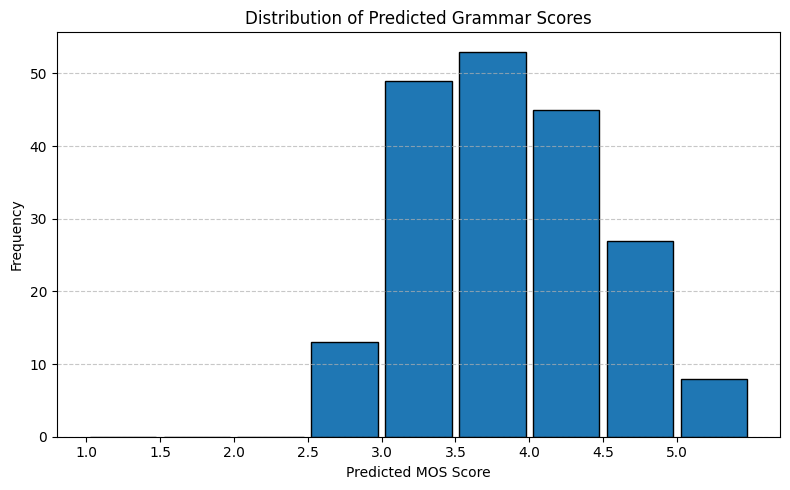

In [11]:
# Plot histogram of predicted labels
output_df = pd.read_csv("test_predictions_regression_submit.csv")
plt.figure(figsize=(8, 5))
plt.hist(output_df['label'], bins=[1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5], edgecolor='black', rwidth=0.9)
plt.xticks([1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0])
plt.xlabel("Predicted MOS Score")
plt.ylabel("Frequency")
plt.title("Distribution of Predicted Grammar Scores")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

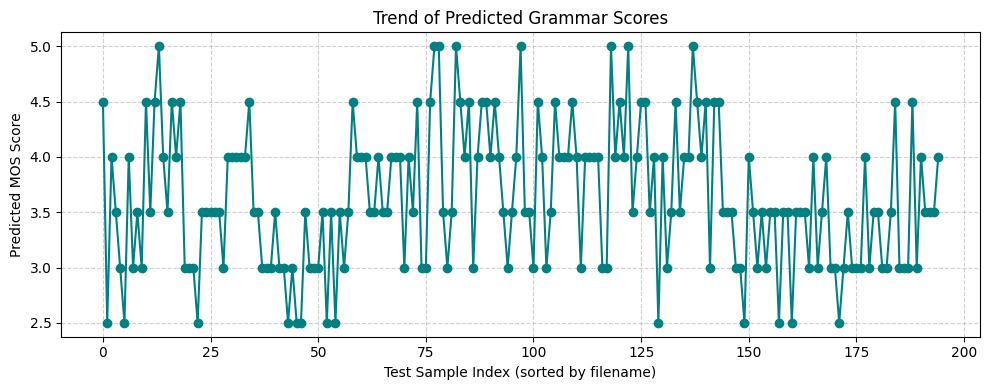

: 

In [ ]:
# Sort by filename (or any order) for trendline visualization
df_sorted = output_df.sort_values('filename')

plt.figure(figsize=(10, 4))
plt.plot(df_sorted['label'].values, marker='o', linestyle='-', color='teal')
plt.xlabel("Test Sample Index (sorted by filename)")
plt.ylabel("Predicted MOS Score")
plt.title("Trend of Predicted Grammar Scores")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

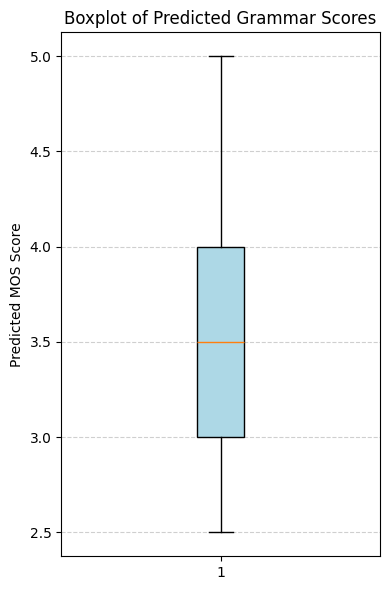

In [13]:
# a statistical summary
plt.figure(figsize=(4, 6))
plt.boxplot(output_df['label'], vert=True, patch_artist=True, boxprops=dict(facecolor='lightblue'))
plt.ylabel("Predicted MOS Score")
plt.title("Boxplot of Predicted Grammar Scores")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()